In [98]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import nltk
import spacy
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [99]:
characters_header = [
    "Wikipedia_ID", "Freebase movie ID", "Release date", 
    "Character name", "Actor date of birth", "Actor gender", 
    "Actor height(meters)", "Actor ethnicity", "Actor name", 
    "Actor age at release", "Freebase character/actor map ID", 
    "Freebase character ID", "Freebase actor ID"
]

In [100]:
dataPath = '../../data/MovieSummaries/'
#Load the data
plot_df = pd.read_csv("../../data/MovieSummaries/plot_summaries.txt", sep='\t')
character_metadata_df = pd.read_csv("../../data/MovieSummaries/character.metadata.tsv", sep='\t')
movie_metadata_df = pd.read_csv("../../data/MovieSummaries/movie.metadata.tsv", sep='\t')

#rename the columns
character_metadata_df.columns = characters_header
plot_df.columns = ['Wikipedia_ID', 'Plot']
movie_metadata_df.columns = ['Wikipedia_ID', 'Freebase movie ID', 'Name', 'Release date', 'Revenue', 'Runtime', 'Languages', 'Countries', 'Genres']

In [101]:
# Merge plot summaries with metadata
movie_plots = plot_df
character_metadata_df = pd.merge(character_metadata_df, movie_metadata_df, on="Wikipedia_ID", how="inner")
merged_df = pd.merge(character_metadata_df, movie_plots, on="Wikipedia_ID", how="inner")

In [102]:
# Vectorize plot summaries
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
plot_matrix = vectorizer.fit_transform(merged_df['Plot'])

# Cluster plots into archetypes
kmeans = KMeans(n_clusters=20, random_state=42)
merged_df['Archetype'] = kmeans.fit_predict(plot_matrix)

# Extract top terms for each cluster
feature_names = vectorizer.get_feature_names_out()

In [103]:
# Extract top terms for each cluster
for i in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-30:][::-1]
    top_terms = [feature_names[j] for j in top_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Cluster 0: team, chris, game, coach, players, football, play, player, league, school, baseball, win, new, championship, season, time, basketball, father, soccer, high, college, ball, members, winning, group, star, playing, world, final, film
Cluster 1: love, village, father, marriage, son, falls, marry, daughter, raj, married, vijay, brother, story, girl, life, ravi, sister, family, comes, gets, mother, singh, karan, man, pooja, house, friend, wife, meets, parents
Cluster 2: david, jim, father, new, family, tells, goes, home, wife, friend, time, life, charlie, car, old, man, love, finds, son, young, later, town, house, children, silver, amy, film, mother, away, tries
Cluster 3: film, story, life, cite, movie, com, web, young, www, http, based, man, characters, follows, woman, set, director, love, character, new, world, women, played, role, ref, plot, films, time, tells, title
Cluster 4: king, prince, queen, princess, kingdom, palace, castle, throne, father, snow, robin, royal, love, sw

In [128]:
#manualy assign archetype names, based on some research

archetype_names = {
    0: "Sport",
    1: "Romantic stories",
    2: "Personal journeys",
    3: "Film industry stories",
    4: "Royal and historical stories",
    5: "Family life and relationships",
    6: "School life and adolescence",
    7: "Personal stories",
    8: "Family interactions",  # Corrected 'Family interations'
    9: "Harry Potter",
    10: "Historical stories",
    11: "New beginnings",
    12: "World War II",
    13: "Town life",
    14: "Crime",
    15: "Science fiction/space exploration",
    16: "Police investigations",
    17: "Family and inter-generational stories",  # Corrected 'Family  and inter-generational stories'
    18: "Indian dramas",
    19: "Everyday life"
}

In [105]:
merged_df['Archetype_Name'] = merged_df['Archetype'].map(archetype_names)


In [107]:
#remove columns Freebase movie ID and Release date
merged_df = merged_df.drop(columns=['Freebase movie ID_x', 'Release date_x'])

In [108]:
merged_df.columns = merged_df.columns.str.replace('_x', '')
merged_df.columns = merged_df.columns.str.replace('_y', '')

Index(['Wikipedia_ID', 'Character name', 'Actor date of birth', 'Actor gender',
       'Actor height(meters)', 'Actor ethnicity', 'Actor name',
       'Actor age at release', 'Freebase character/actor map ID',
       'Freebase character ID', 'Freebase actor ID', 'Freebase movie ID',
       'Name', 'Release date', 'Revenue', 'Runtime', 'Languages', 'Countries',
       'Genres', 'Plot', 'Archetype', 'Archetype_Name'],
      dtype='object')

In [109]:
#keep only films after 1960
merged_df['Release date'] = pd.to_datetime(merged_df['Release date'], errors='coerce')
merged_df = merged_df[merged_df['Release date'] > '1960-01-01']

In [ ]:
merged_df["Release date"] = merged_df["Release date"].dt.year

In [120]:
merged_df['Release date'] = merged_df['Release date'].astype(str)

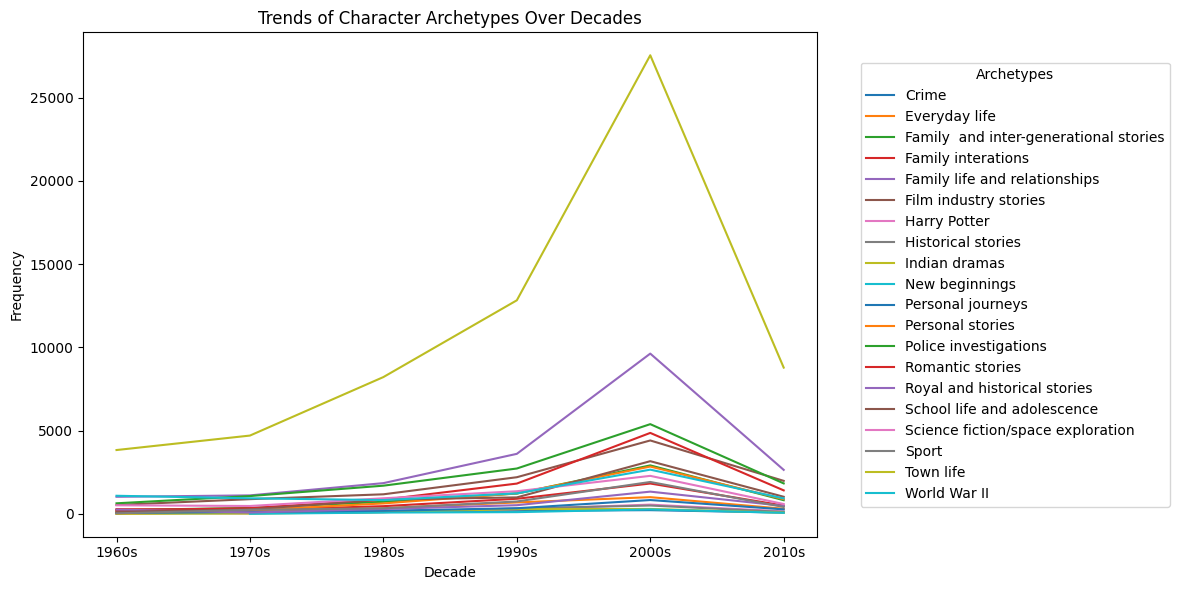

In [132]:
# Group by archetype names and decade
merged_df['Decade'] = merged_df['Release date'].str[:3] + '0s'
archetype_trends = merged_df.groupby(['Decade', 'Archetype_Name']).size().unstack()

# Plot trends
ax = archetype_trends.plot(kind='line', figsize=(12, 6))
plt.title("Trends of Character Archetypes Over Decades")
plt.xlabel("Decade")
plt.ylabel("Frequency")

# Move the legend to the side (outside of the plot)
plt.legend(title="Archetypes", bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [122]:
# Merge character archetypes with movie metadata
archetype_revenue = pd.merge(merged_df, movie_metadata_df, on='Wikipedia_ID')

In [123]:
#delete duplicates: Name_x, Release date_x, Revenue_x, Runtime_x, Languages_x, Countries_x, Genres_x
archetype_revenue = archetype_revenue.drop(['Name_x', 'Release date_x', 'Revenue_x', 'Runtime_x', 'Languages_x', 'Countries_x', 'Genres_x'], axis=1)
#rename the columns by deleting the _x and _y
archetype_revenue.columns = archetype_revenue.columns.str.replace('_x', '')
archetype_revenue.columns = archetype_revenue.columns.str.replace('_y', '')

In [124]:
archetype_revenue['Revenue'] = pd.to_numeric(archetype_revenue['Revenue'], errors='coerce')

In [125]:
##only keep some columns
archetype_revenue = archetype_revenue[['Archetype_Name', 'Decade', 'Revenue']]

# Calculate average revenue by Archetype_Name and Decade
archetype_revenue_avg = (
    archetype_revenue.groupby(['Archetype_Name', 'Decade'], as_index=False)['Revenue']
    .mean()
    .rename(columns={'Revenue': 'Average_Revenue'})
)

In [126]:
# Pivot data for stacked line chart
archetype_revenue_pivot = archetype_revenue_avg.pivot(
    index='Decade',
    columns='Archetype_Name',
    values='Average_Revenue'
)

# Fill NaN with 0 (if any) to avoid issues with stacking
archetype_revenue_pivot = archetype_revenue_pivot.fillna(0)


<Figure size 1200x800 with 0 Axes>

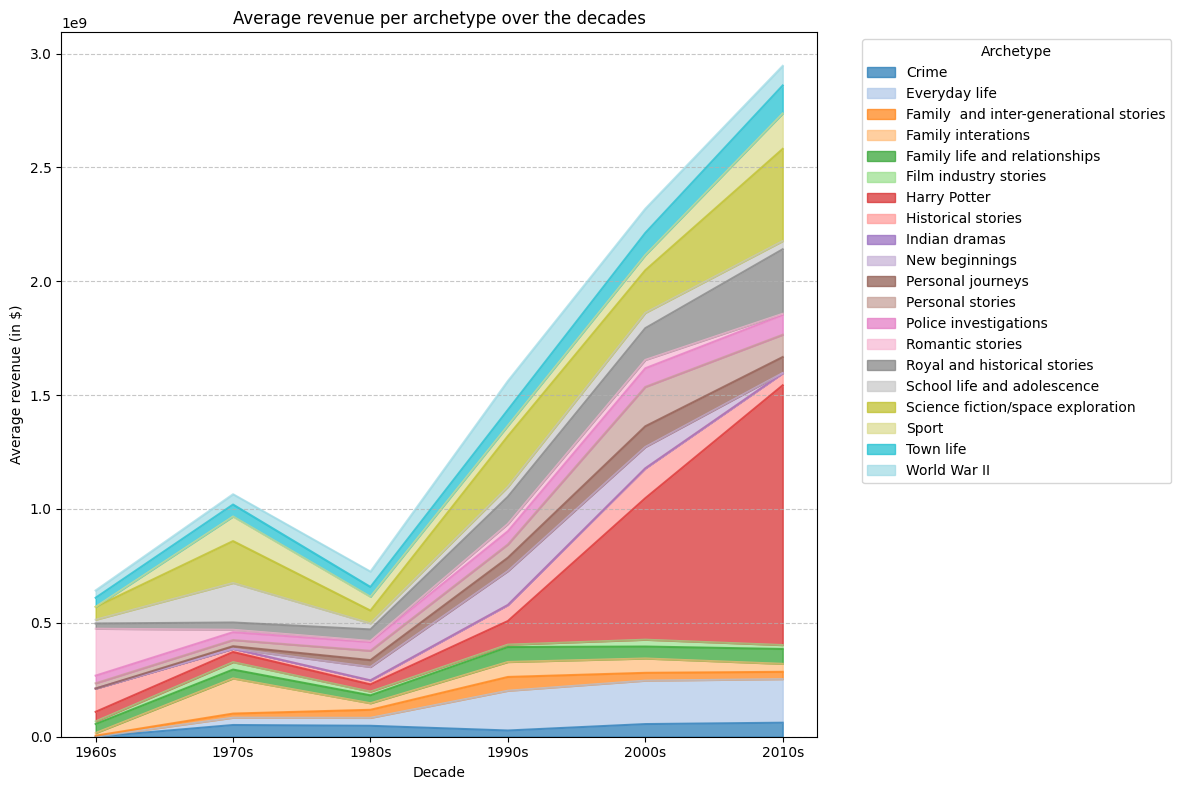

In [133]:
# Plot the stacked line chart (area chart)
plt.figure(figsize=(12, 8))

# Use the stacked area plot
archetype_revenue_pivot.plot.area(
    alpha=0.7,
    figsize=(12, 8),
    cmap='tab20',  # Color palette
    xlabel='Decade',
    ylabel='Average revenue (in $)',
    title='Average revenue per archetype over the decades'
)

# Add a legend
plt.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


sentiment analysis based on the archetype of the film